This notebook shows how do we use the shap package and the evaluation underlying each chart. We will be analyzing the different models based on their use cases.

# Import and load

In [159]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import joblib
from sklearn.model_selection import train_test_split
import torch
from torch import nn
import shap
shap.initjs()

# Display all columns and rows
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

class SimpleNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super().__init__()
        self.hidden1 = nn.Linear(input_dim, hidden_dim)
        self.relu1 = nn.ReLU()
        self.hidden2 = nn.Linear(hidden_dim, hidden_dim)
        self.relu2 = nn.ReLU()
        self.output = nn.Linear(hidden_dim, output_dim)
    def forward(self, x):
        x = self.relu1(self.hidden1(x))
        x = self.relu2(self.hidden2(x))
        x = self.output(x)
        return x

In [2]:
# Load datasets
df_accident = pd.read_pickle('./data/processed/accident.pkl')
df_iris = pd.read_pickle('./data/processed/iris.pkl')
df_student = pd.read_pickle('./data/processed/student_performance.pkl')

# True value (Optional)
y_accident = df_accident["Survived"]
y_iris = df_iris["label"]
y_student = df_student["Performance Index"]

# GET Features dataset
df_accident.drop(columns=["Survived"], inplace=True)
df_iris.drop(columns=["label"], inplace=True)
df_student.drop(columns=["Performance Index"], inplace=True)

In [5]:
# load models
lr = joblib.load("./models/accident_lr.pkl")
dt = joblib.load("./models/accident_dt.pkl")
rf = joblib.load("./models/accident_rf.pkl")
xbg = joblib.load("./models/iris_xbg.pkl")
# model = torch.jit.load("./models/student_nn.pt")
model = torch.load("./models/student_nn.pt", weights_only=False)
model.eval()

SimpleNN(
  (hidden1): Linear(in_features=5, out_features=8, bias=True)
  (relu1): ReLU()
  (hidden2): Linear(in_features=8, out_features=8, bias=True)
  (relu2): ReLU()
  (output): Linear(in_features=8, out_features=1, bias=True)
)

# Test Inference

In [6]:
y_pred_accident = rf.predict(df_accident)
y_pred_iris = xbg.predict(df_iris)
y_pred_tensor = model(torch.tensor(df_student.values, dtype=torch.float32)).detach().numpy()

print(y_pred_accident.shape, y_pred_iris.shape, y_pred_tensor.shape)

(196,) (3000,) (10000, 1)


In [135]:
shap_model = rf
shap_pred = shap_model.predict_proba(df_accident.iloc[:,:]) #predict_proba
print("\n--------- SHAPE ---------")
print("X shape:", df_accident.shape)
print("y_pred shape:", shap_pred.shape)

print("\n--------- MEAN ---------")
print("y_pred mean:", np.mean(shap_pred[:,:], axis=0))
print("y_pred mean (100):", np.mean(shap_pred[:100,:], axis=0))

explainer = shap.Explainer(shap_model, df_accident.iloc[:100,:]) # Backgound Data: df_accident (random sample)
print("\n--------- Expected_value = MEAN (PRED) ---------")
print("SHAP Base: ", explainer.expected_value)

print("\n--------- ADDITIVE - record 1 ---------")
shap_explainer = explainer(df_accident.iloc[:3,:])
print("Expected:", shap_pred[1,:])
print("SHAP value:", shap_explainer[1,:,:].values)
print("additive (base + shap = expected):", np.sum(shap_explainer[1,:,:].values, axis=0) + shap_explainer[1,:,:].base_values)


--------- SHAPE ---------
X shape: (196, 5)
y_pred shape: (196, 2)

--------- MEAN ---------
y_pred mean: [0.48642857 0.51357143]
y_pred mean (100): [0.4837 0.5163]

--------- Expected_value = MEAN (PRED) ---------
SHAP Base:  [0.4837 0.5163]

--------- ADDITIVE - record 1 ---------
Expected: [0.22 0.78]
SHAP value: [[-0.22486833  0.22486833]
 [ 0.00192333 -0.00192333]
 [-0.06055167  0.06055167]
 [-0.00361833  0.00361833]
 [ 0.023415   -0.023415  ]]
additive (base + shap = expected): [0.22       0.77999999]


# SHAP - Accident
## Analysis  (random forest)
- On average, the model predict 51.6% of the times that it will result in an accident.
- Local Intereptation - 2nd record (TARGET_IDX) : 78% accident
    - Age contributes the most to it becoming an accident.
    - Him being a guy actually brings down the rate of it becoming an accident (although to a small extent) and is more impactful than using seatbelt or speed of impact.
    - Speed_of_impact does not really contribute to the model calculation in this case.
- Global Intereptation
    - Age and speed_of_impact actually contribute most in determining whether it is an accident (on average)
    - You can tell that there is a clear relation between gender/seatbelt and accident probability (summary/beeswarm plot)
        - Generally, wearing seatbelt and being a guy will result in the model predicting it becoming an accident. On hindsight, this statement might not be true and more analysis might need to be done.
    - Model tends to predict higher accident probability for people who `wear helmet, high speed_of_impact` and `does not wear helmet, low speed_of_impact`


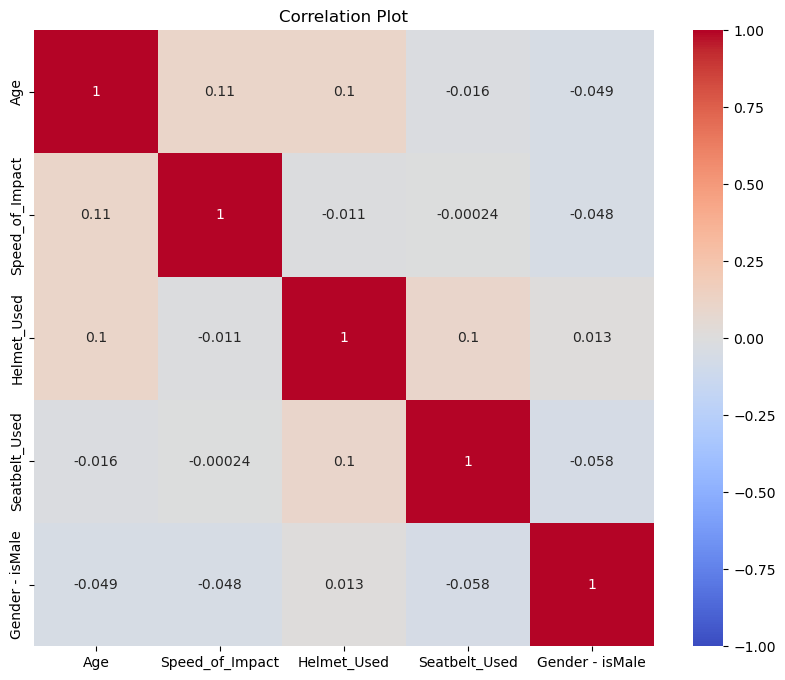

In [160]:
# Calculate the correlation matrix
correlation_matrix = df_accident.corr()

# Create a correlation plot
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Plot')
plt.show()

In [ ]:
shap_model = rf
explainer = shap.Explainer(shap_model)
shap_explainer = explainer(df_accident) # check_additivity=False if error

In [145]:
TARGET_IDX = 1
print("PREDICTION:", shap_model.predict_proba(df_accident)[TARGET_IDX])
print("PREDICTION:", shap_model.predict(df_accident)[TARGET_IDX])

PREDICTION: [0.22 0.78]
PREDICTION: 1


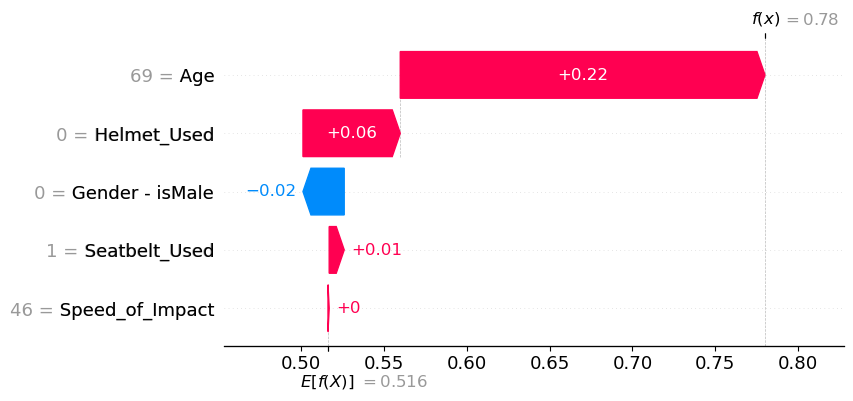

In [173]:
# Local
shap.plots.waterfall(shap_explainer[TARGET_IDX+0,:,1])

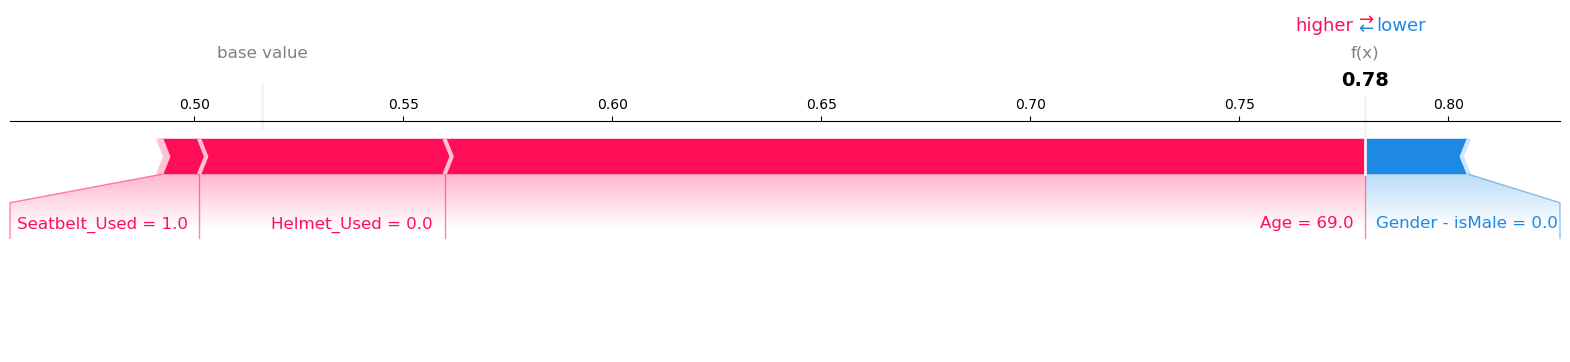

In [ ]:
# Local
shap.force_plot(explainer.expected_value[1], shap_explainer.values[TARGET_IDX, :, 1], df_accident.iloc[TARGET_IDX, :], matplotlib = True) # , link="logit"

In [202]:
shap.plots.force(explainer.expected_value[1], shap_explainer.values[:,:,1], df_accident.iloc[:, :])

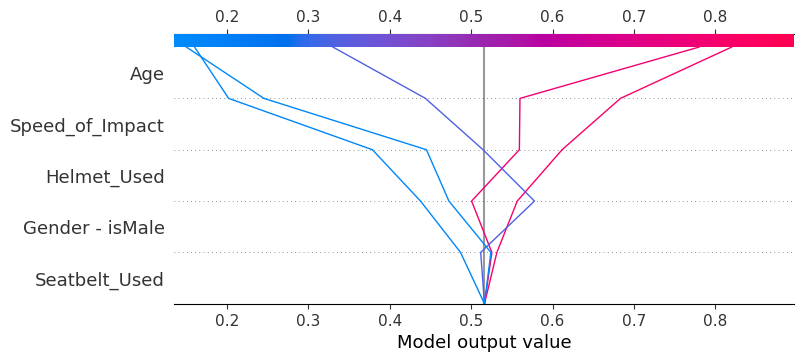

In [206]:
shap.decision_plot(explainer.expected_value[1], shap_explainer.values[:5,:,1], df_accident.columns)

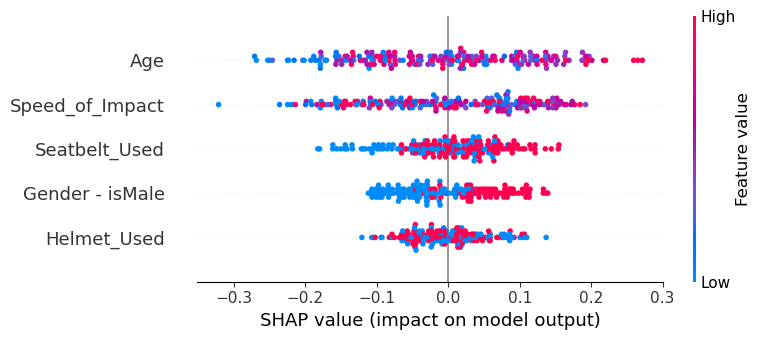

In [169]:
# Global
shap.summary_plot(shap_explainer.values[:,:,1], df_accident.astype("float"))

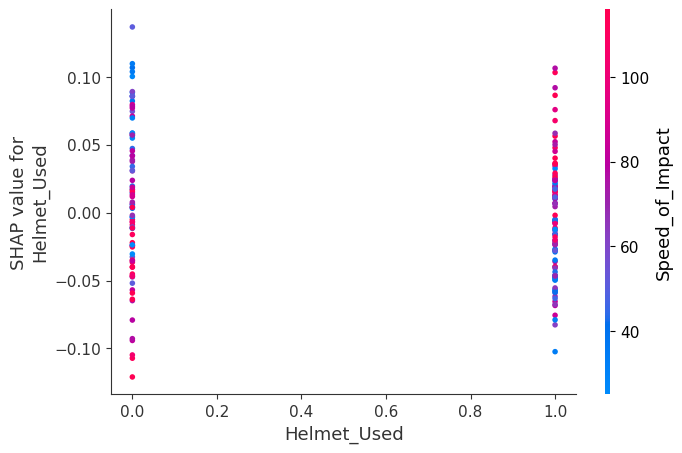

In [200]:
shap.dependence_plot("Helmet_Used", shap_explainer.values[:,:,1], df_accident, interaction_index="Speed_of_Impact")

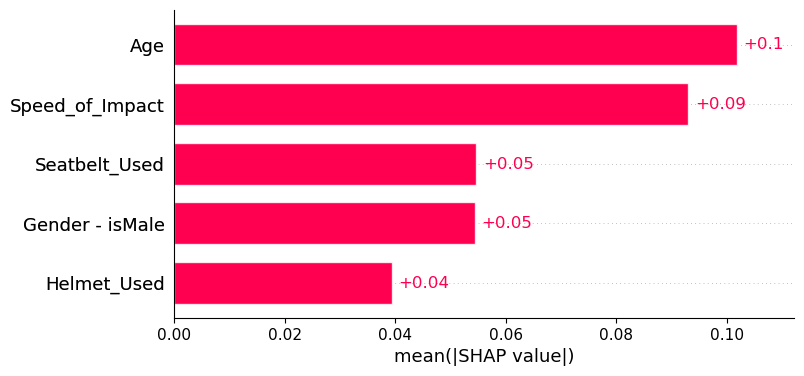

In [ ]:
# Global
shap.plots.bar(shap_explainer[:,:,1])

# SHAP - Iris

In [39]:
explainer = shap.Explainer(xbg)
shap_explainer = explainer(df_iris)

# SHAP - Student Performance

In [90]:
# explainer = shap.DeepExplainer(model, torch.tensor(df_student.iloc[:50, :].values, dtype=torch.float32)) # torch.tensor(df_student.iloc[:50, :].values, dtype=torch.float32)
# shap_explainer = explainer(torch.tensor(df_student.iloc[150:350, :].values, dtype=torch.float32))

f = lambda x: model( torch.tensor(x, dtype=torch.float32) ).detach().numpy()
explainer = shap.KernelExplainer(f, df_student.iloc[:50, :])
shap_explainer = explainer(df_student.iloc[50:150, :])
feature_names = df_student.columns

100%|██████████| 100/100 [00:01<00:00, 86.72it/s]


y_true: 27.0


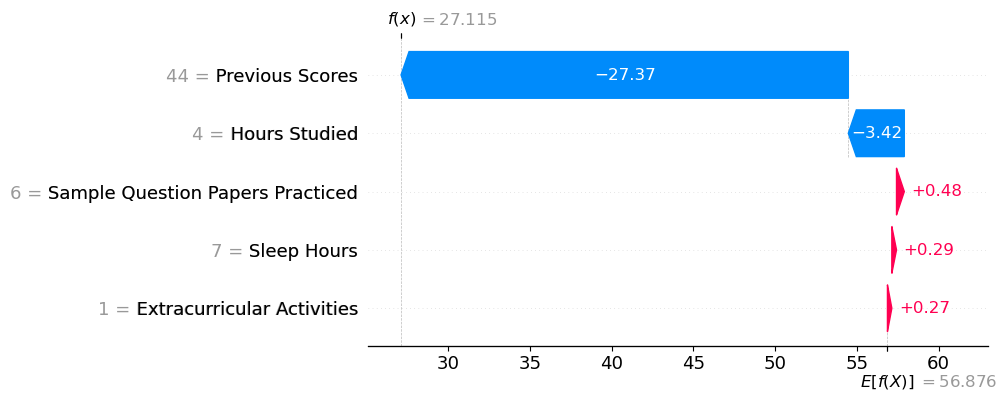

In [106]:
student_idx = 0
print("y_true:", y_student.iloc[student_idx +50])
shap.plots.waterfall(shap_explainer[student_idx,:,0])

In [ ]:
shap_explainer.shape

(1000, 26, 2)

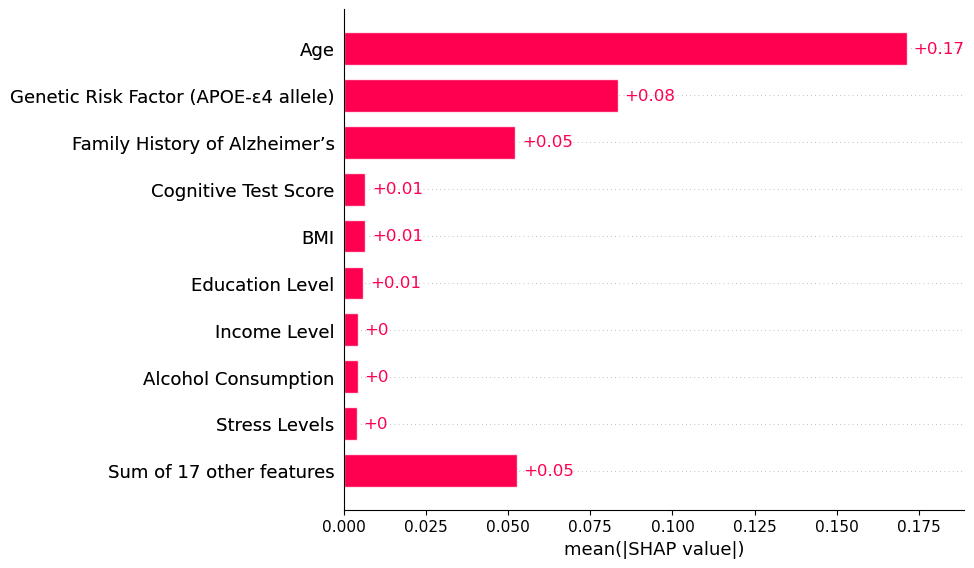

In [ ]:
shap.plots.bar(shap_explainer[:,:,0])

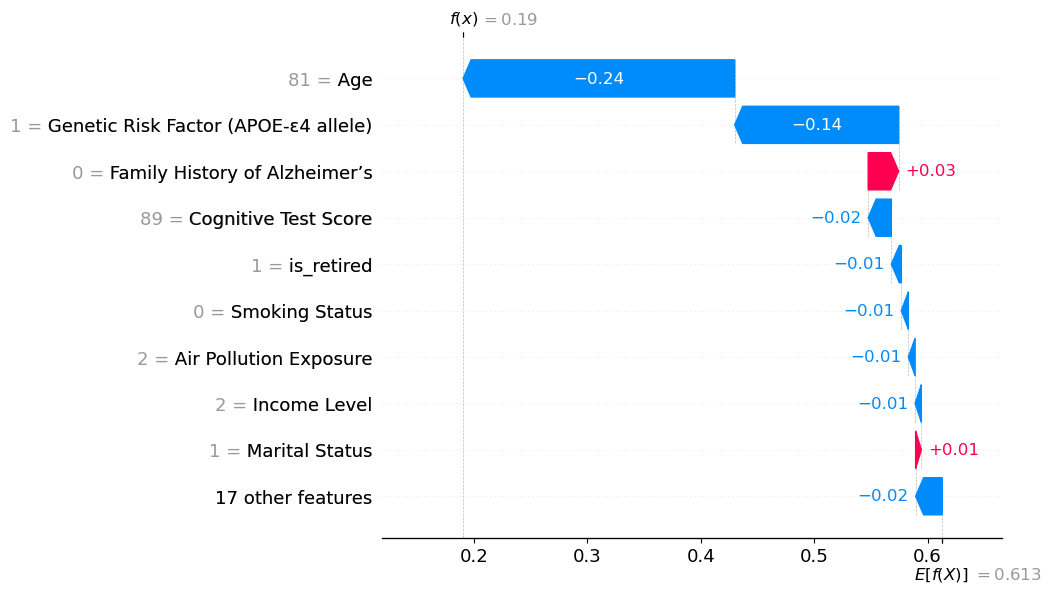

In [ ]:
shap.plots.waterfall(shap_explainer[0,:,0])

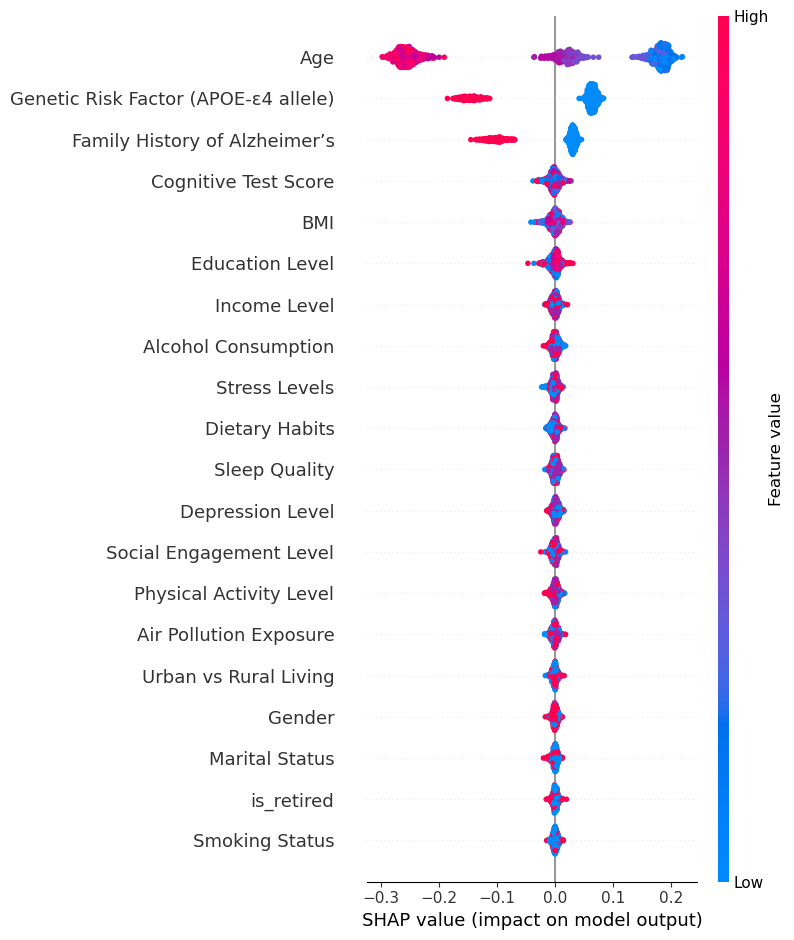

In [ ]:
shap.summary_plot(shap_values[:,:,0], X100.astype("float"))


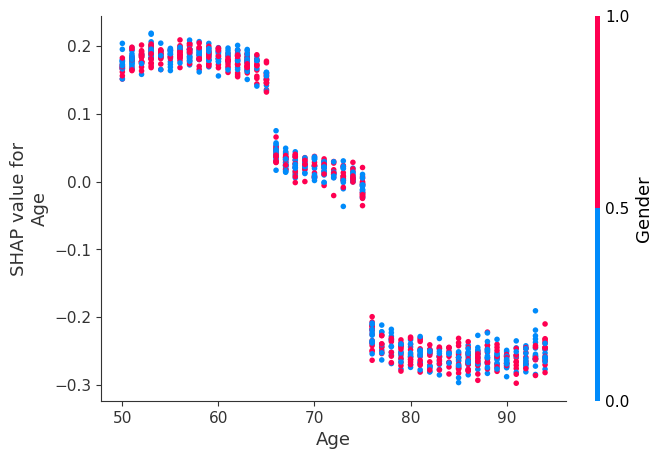

In [ ]:
shap.dependence_plot("Age", shap_values[:,:,0], X100, interaction_index="Gender")

In [ ]:

X100.iloc[0, :]

Age                                     81.0
Gender                                   1.0
Education Level                         17.0
BMI                                     19.4
Physical Activity Level                  1.0
Smoking Status                           0.0
Alcohol Consumption                      2.0
Diabetes                                 0.0
Hypertension                             0.0
Cholesterol Level                        0.0
Family History of Alzheimer’s            0.0
Cognitive Test Score                    89.0
Depression Level                         1.0
Sleep Quality                            1.0
Dietary Habits                           1.0
Air Pollution Exposure                   2.0
Employment Status                        0.0
Marital Status                           1.0
Genetic Risk Factor (APOE-ε4 allele)     1.0
Social Engagement Level                  2.0
Income Level                             2.0
Stress Levels                            1.0
Urban vs R

In [ ]:
y_pred_test = rf.predict(np.expand_dims(X100.iloc[0, :], axis=0))
y_pred_test_log_prob = rf.predict_log_proba(np.expand_dims(X100.iloc[0, :], axis=0))
y_pred_test_prob = rf.predict_proba(np.expand_dims(X100.iloc[0, :], axis=0))
print(y_pred_test, y_pred_test_log_prob, y_pred_test_prob)

[1] [[-1.66073121 -0.21072103]] [[0.19 0.81]]


c:\Users\gansh\miniconda3\envs\xai\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
c:\Users\gansh\miniconda3\envs\xai\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
c:\Users\gansh\miniconda3\envs\xai\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


()
(26,)
(26,)


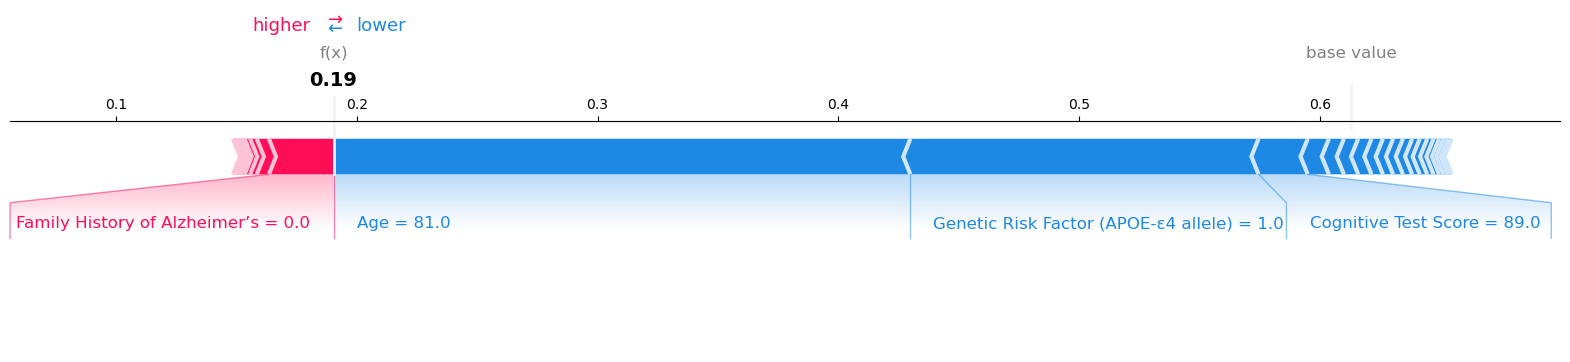

In [ ]:
print(explainer.expected_value[0].shape)
print(shap_values[0,:,0].shape)
print(X100.iloc[0, :].shape)

shap.plots.force(explainer.expected_value[0], shap_values[0,:,0], X100.iloc[0, :], matplotlib = True)

In [ ]:
shap.plots.force(explainer.expected_value[0], shap_values[:100,:,0], X100.iloc[:100, :])

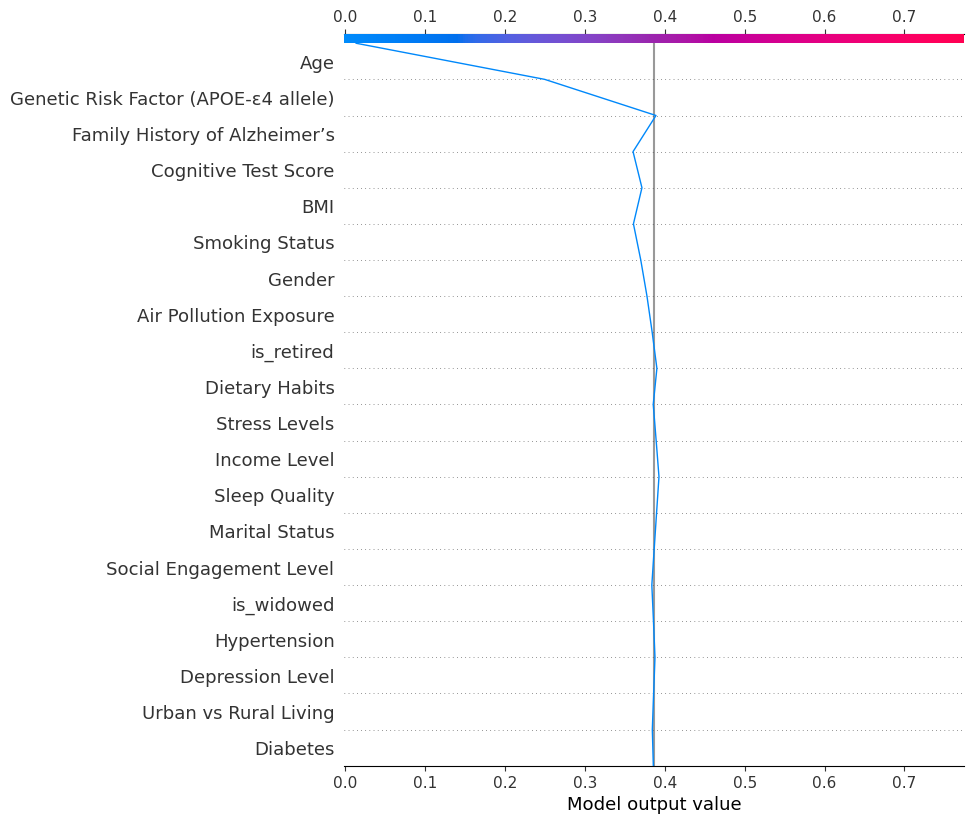

In [ ]:
shap.decision_plot(explainer.expected_value[1], shap_values[0,:,0], X100.columns)

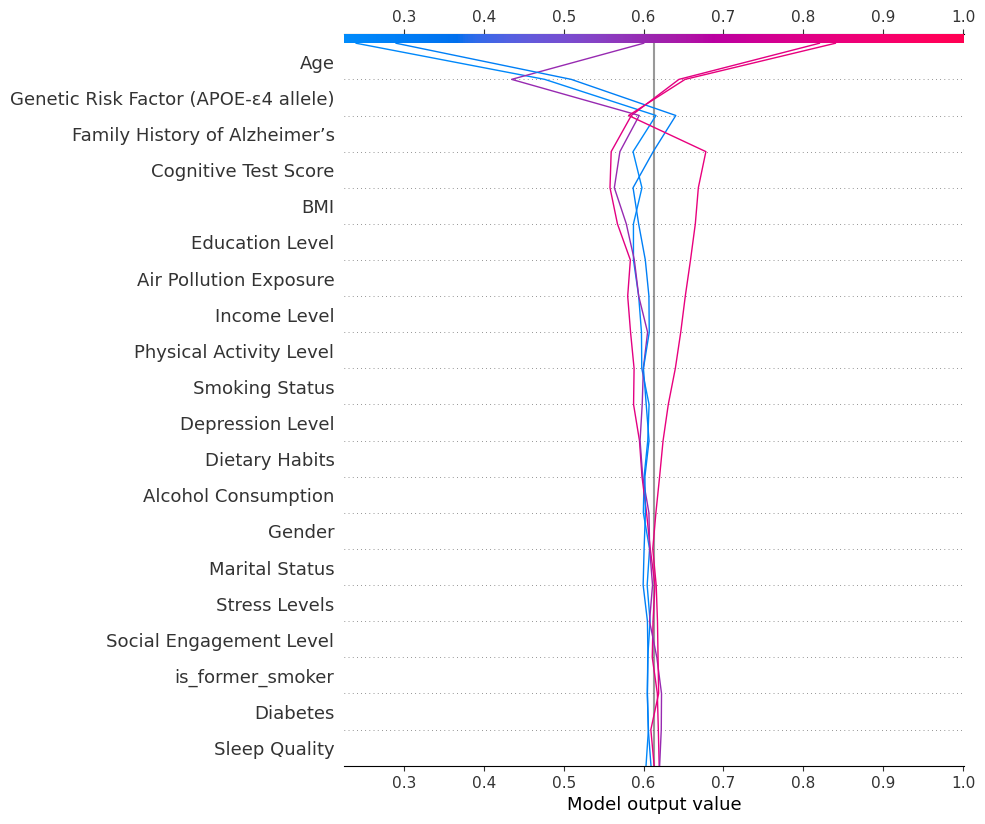

In [ ]:
shap.decision_plot(explainer.expected_value[0], shap_values[:5,:,0], X100.columns)

In [ ]:
shap_explainer[:100,0,0].shape

(100,)

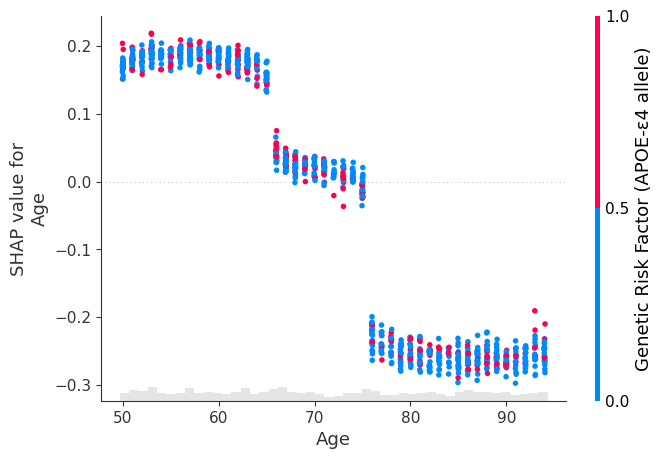

In [ ]:
shap.plots.scatter(shap_explainer[:,0,0], color=shap_explainer[:,:,0])